# Convert and visualize text bounding boxes


In this example we will use the output of the converted document and create an image of elements detected on each page.




### System dependencies
This script is converting a PDF document with Deep Search and exports the figures into PNG files.

The PDF to image conversion relies on the `pdftoppm` executable of the Poppler library (GPL license)
https://poppler.freedesktop.org/
The Poppler library can be installed from the most common packaging systems, for example
- On macOS, `brew install poppler`
- On Debian (and Ubuntu), `apt-get install poppler-utils`
- On RHEL, `yum install poppler-utils`


### Notebooks parameters

The following block defines the parameters used to execute the notebook

- `INPUT_FILE`: the input PDF to converted and analyzed
- `SHOW_PDF_IMAGE`: if enabled, the background will contain the rendered PDF page
- `SHOW_CLUSTER_BOXES`: if enabled, the cluster boxes will be visualized
- `SHOW_TEXT_CELLS_BOXES`: if enabled, the PDF raw text cells will be visualized


In [1]:
from dsnotebooks.settings import ProjectNotebookSettings
from pathlib import Path

# notebooks settings auto-loaded from .env / env vars
notebook_settings = ProjectNotebookSettings()

PROFILE_NAME = notebook_settings.profile  # the profile to use
PROJ_KEY = notebook_settings.proj_key     # the project to use
# INPUT_FILE = Path("../../data/samples/2206.01062.pdf")
INPUT_FILE = Path("../../data/samples/2206.00785.pdf")

# Visualization options. Which layers should be included in the visualization
SHOW_PDF_IMAGE = True
SHOW_CLUSTER_BOXES = True
SHOW_TEXT_CELLS_BOXES = True

## Helper functions

The following blocks define the helper functions used for the visualization of the output

In [2]:
# Import standard dependenices
import json
import tempfile
import typing
from zipfile import ZipFile

# Dependencies for the visualization
import math
from PIL import Image, ImageDraw
from IPython.display import display, Markdown, HTML, display_html
import base64
import io
from subprocess import check_call, CalledProcessError

# Import the deepsearch-toolkit
import deepsearch as ds

In [3]:
def resolve_item(raw_item, doc):
    """
    Resolved jsonref used in the main-text document items
    """
    if not "$ref" in raw_item:
        return raw_item
    parts = raw_item["$ref"].split("/")
    item = doc
    for i, k in enumerate(parts[1:]):
        if isinstance(item, typing.Mapping) and not k in item:
            print(f"k={k} not found")
            return {}
        
        if isinstance(item, typing.List):
            try:
                k = int(k)
            except:
                print(f"cannot cast {k} to int")
                return {}
        item = item[k]
    return item

In [4]:
def page_elements_from_json_document(doc_jsondata):
    """
    Collect all the document elements with a bounding box
    and organize them per page.

    Parameters
    ----------
    doc_jsondata : 
        Converted document

    Returns
    -------
    Dict[PageNumber, List[BoxDescription]]
        A dictionary mapping the page number to a list of the
        document boxes on that page.
        BoxDescription will contain the page, type, and bbox.
    """
    clusters = {}
    for raw_item in doc_jsondata["main-text"]:
        item = resolve_item(raw_item, doc_jsondata)
        if not "prov" in item:
            print("PROV not found")
            print(item)
            continue
        page = item["prov"][0]["page"]
        item_type = item["type"]
        clusters.setdefault(page, []).append({
            "page": page,
            "type": item_type,
            "bbox": item["prov"][0]["bbox"],
        })
    return clusters

In [5]:
def page_elements_from_text_cells(doc_cellsdata):
    """
    Collect all the text cells with a bounding box and
    organize them per page.

    Parameters
    ----------
    doc_cellsdata : 
        Cells document provided by the Deep Search conversion

    Returns
    -------
    Dict[PageNumber, List[BoxDescription]]
        A dictionary mapping the page number to a list of the
        document boxes on that page.
        BoxDescription will contain the page, type, and bbox.
    """

    cells = {}
    for item in doc_cellsdata["cells"]["data"]:
        page = item[0]+1
        item_type = item[5]
        cells.setdefault(page, []).append({
            "page": page,
            "type": item_type,
            "bbox": item[1:5],
        })

    return cells

In [6]:
# The 
labels_colors_clusters = {
    "table": ((240, 128, 128, 100), (255,0,0)),
    "caption": ((243, 156, 18, 100), (255,0,0)),
    "citation": ((14, 210, 234, 100), (255,0,0)),
    "picture": ((255, 236, 204, 100), (255,0,0)),
    "formula": ((128, 139, 150, 100), (255,0,0)),
    "subtitle-level-1": ((204, 51, 102, 100), (255,0,0)),
    "paragraph": ((234, 234, 43, 100), (255,0,0)),
}

labels_colors_cells = {
    "table": ((240, 128, 128, 100), (0,0,0,0)),
    "caption": ((243, 156, 18, 100), (0,0,0,0)),
    "citation": ((14, 210, 234, 100), (0,0,0,0)),
    "picture": ((255, 236, 204, 100), (0,0,0,0)),
    "formula": ((128, 139, 150, 100), (0,0,0,0)),
    "subtitle-level-1": ((204, 51, 102, 100), (0,0,0,0)),
    "paragraph": ((234, 234, 43, 100), (0,0,0,0)),
}

def draw_boxes(img, dims, boxes, colors_map={}):
    """
    Draw bounding boxes on the input PIL Image `img`
    
    Parameters
    ----------
    img : Image
        PIL image on which the boxes are drawn.
    dims : List[int]
        Page dimensions as `dims=(width, height)`.
    boxes : List[dict]
        List of boxes to draw, in the format of `{type: str, bbox: List[int]`}.
    colors_map : Dict[str, Tuple[RGBA, RGBA]]
        Dictionary with the color to use for the bbox, the map value is a tuple
        of style for the fill color and for the line color.
        Colors can be defined as a list of RGB or RGBA, with values in the range
        0 to 255.
    """
    drw = ImageDraw.Draw(img, "RGBA")
    for cluster in boxes:

        bbox = cluster["bbox"]
        rect = [
            round(bbox[0]),
            round(dims[1]-bbox[3]),
            round(bbox[2]),
            round(dims[1]-bbox[1])
        ]
        
        c_fill, c_outline = colors_map.get(cluster["type"].lower(), ((128,128,128,100), (0,0,0,0)))
        drw.rectangle(rect, outline=c_outline, fill=c_fill)

In [7]:
def pdf_to_page_image(pdf_filename, page, resolution=72):
    """
    Convert the page number `page` of the PDF document to an image
    
    Parameters
    ----------
    pdf_filename : Path
        Input PDF file.
    page : int
        Page number where the bounding box is located.
    resolution : int, Default=72
        Resolution of the extracted image.

    Returns
    -------
    Image
        PIL Image of the PDF page.
    """

    with tempfile.NamedTemporaryFile() as output_file:
        output_filename = output_file.name
        cmd = [
            "pdftoppm",
            "-png",
            "-singlefile",
            "-f", str(page), "-l", str(page),
            "-cropbox",
            "-r", str(resolution),
            pdf_filename,
            output_filename,
        ]
        try:
            check_call(cmd)
        except CalledProcessError as cpe:
            raise RuntimeError(
                f"PDFTOPPM PROCESSING ERROR. Exited with: {cpe.returncode}"
            ) from cpe
        png_file = output_filename + ".png"
        img = Image.open(png_file)
        return img


In [8]:
def visualize_document_bboxes(doc_jsondata, doc_cellsdata, ncols=3):
    """
    Visualize the document pages overlaying the PDF image with the 
    bounding boxes of the text cells and the segmentation clusters.
    
    Parameters
    ----------
    doc_jsondata :
        Converted document
    doc_cellsdata :
        Cells document provided by the Deep Search conversion
    ncols : int, Default=3
        Number of columns in the display table.
    """
    
    clusters = page_elements_from_json_document(doc_jsondata)
    cells = page_elements_from_text_cells(doc_cellsdata)
    pages_to_dims = {dims["page"]: dims for dims in doc_jsondata["page-dimensions"]}
    
    output_html = "<table>"
    for i, page in enumerate(sorted(clusters.keys())):
        dims = pages_to_dims[page]["width"], pages_to_dims[page]["height"]
        page_cells = cells[page]
        page_clusters = clusters[page]

        if SHOW_PDF_IMAGE:
            img = pdf_to_page_image(INPUT_FILE, page=page)
            img = img.resize((math.ceil(dims[0]), math.ceil(dims[1])))
        else:
            img = Image.new("RGB", (math.ceil(dims[0]), math.ceil(dims[1])), (255, 255, 255))
            img = img.resize((math.ceil(dims[0]), math.ceil(dims[1])))

        # Draw page rectangle
        drw = ImageDraw.Draw(img)
        drw.rectangle([0,0,dims[0]-1, dims[1]-1], outline=(0,0,0))

        # Draw bounding boxes
        if SHOW_TEXT_CELLS_BOXES:
            draw_boxes(img, dims, page_cells, labels_colors_cells)
        if SHOW_CLUSTER_BOXES:
            draw_boxes(img, dims, page_clusters, labels_colors_clusters)

        if i == 0:
            output_html += "<tr>"
        elif i % ncols == 0:
            output_html += "</tr><tr>"


        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        img_str = base64.b64encode(buffer.getvalue()).decode("utf8")

        output_html += "<td>"
        output_html += f"<strong>Page {page}</strong><br />"
        output_html += f"<img src='data:image/png;base64,{img_str}' />"
        output_html += "</td>"


    output_html += "</tr></table>"
    display(HTML(output_html))

## Document conversion and visualization with Deep Search

In [9]:
# Connect to Deep Search
api = ds.CpsApi.from_env(profile_name=PROFILE_NAME)

In [10]:
# Launch the document conversion
documents = ds.convert_documents(
    api=api, proj_key=PROJ_KEY, source_path=INPUT_FILE, progress_bar=True
)


Converting input:     : 100%|██████████████████████████████| 1/1 [00:23<00:00, 23.38s/it]                                                                                                                 


In [11]:
# Download results
output_dir = tempfile.mkdtemp() # TODO: switch to tempfile.TemporaryDirectory() and use `with`
documents.download_all(result_dir=output_dir, progress_bar=True)


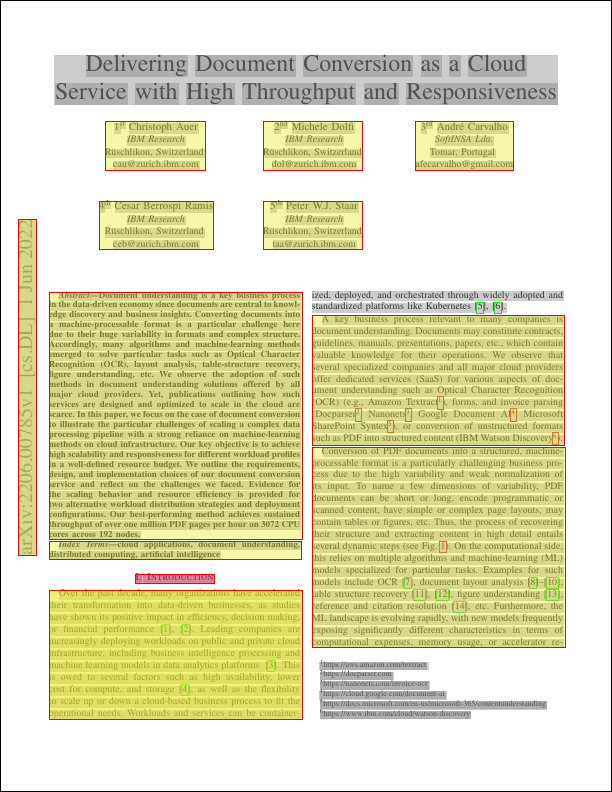
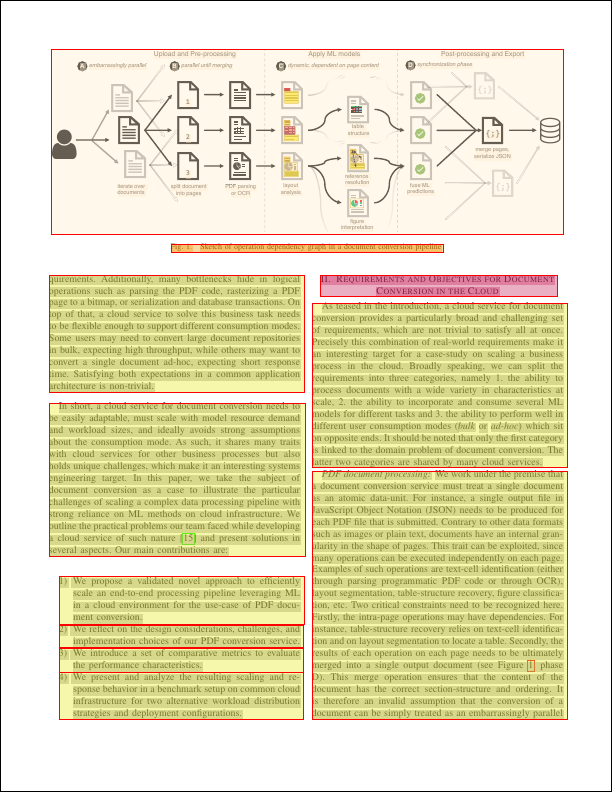
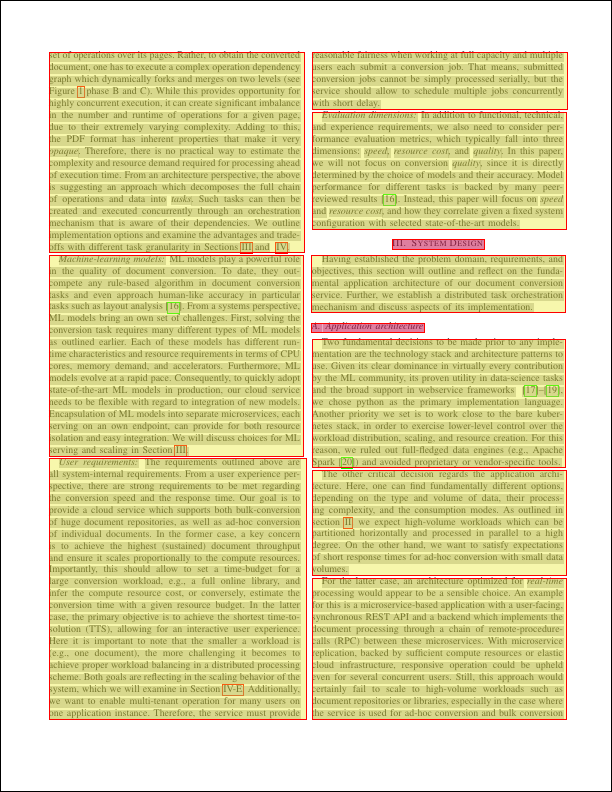
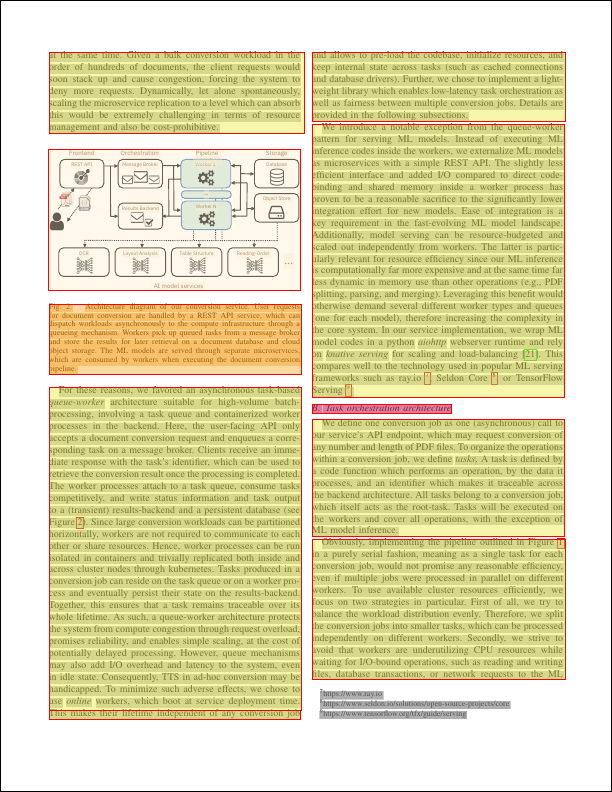
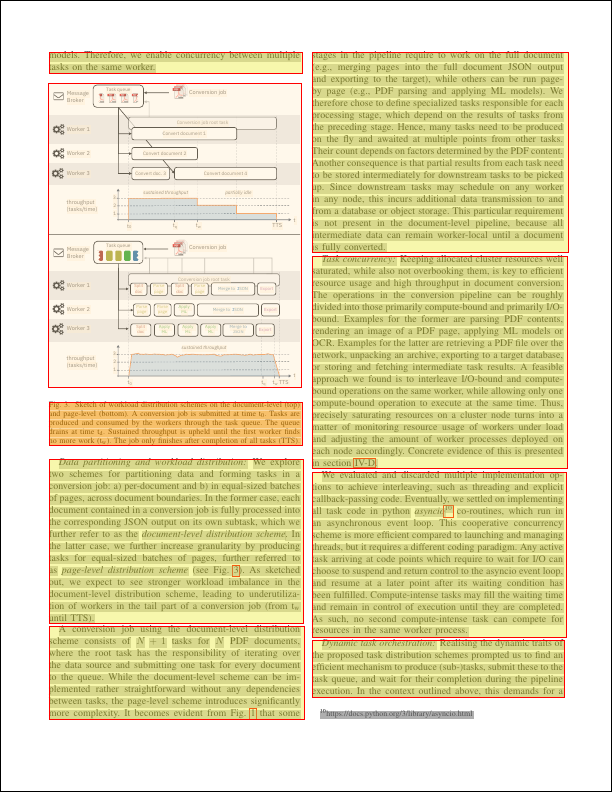
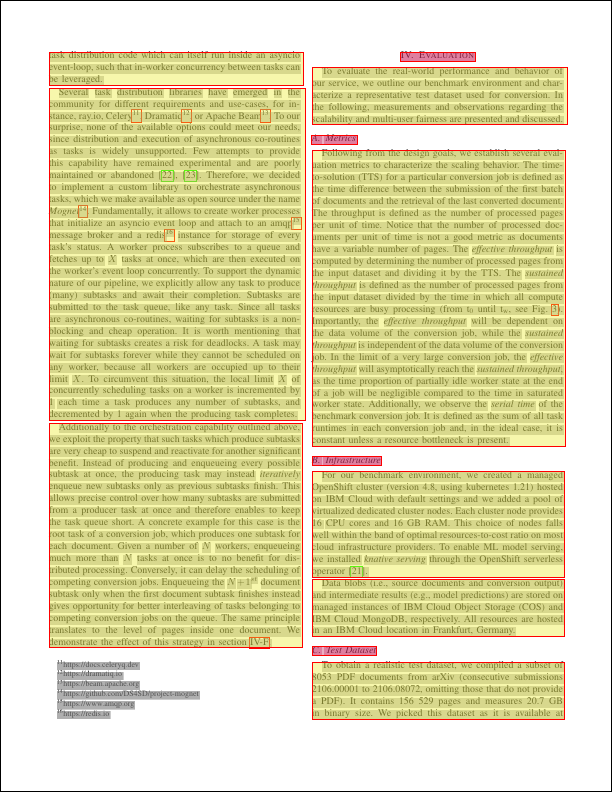
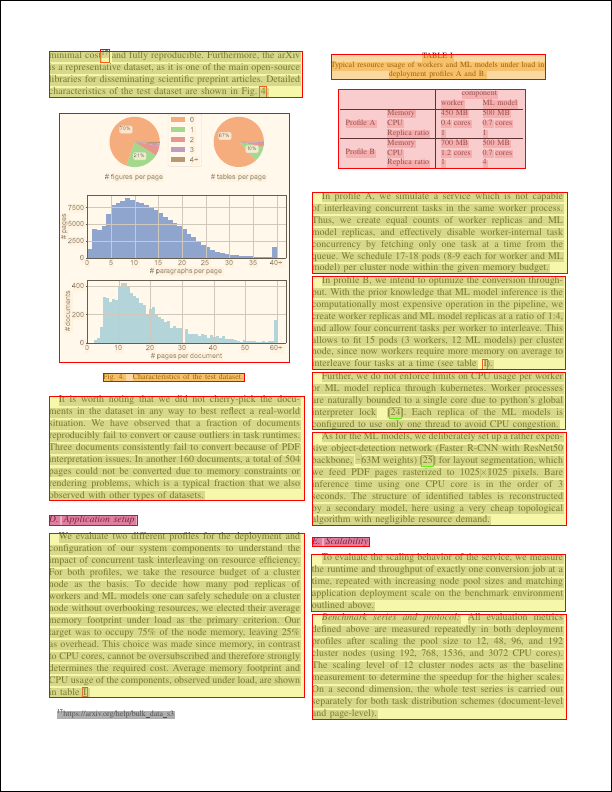
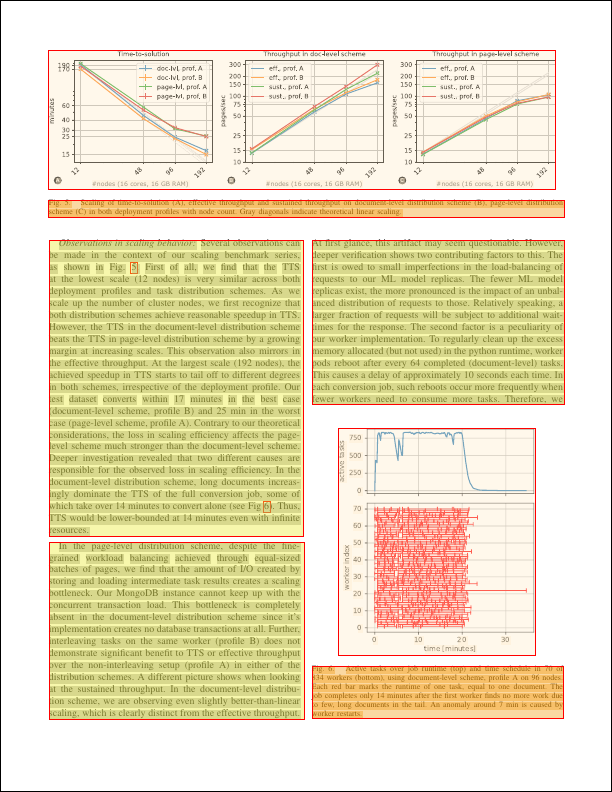
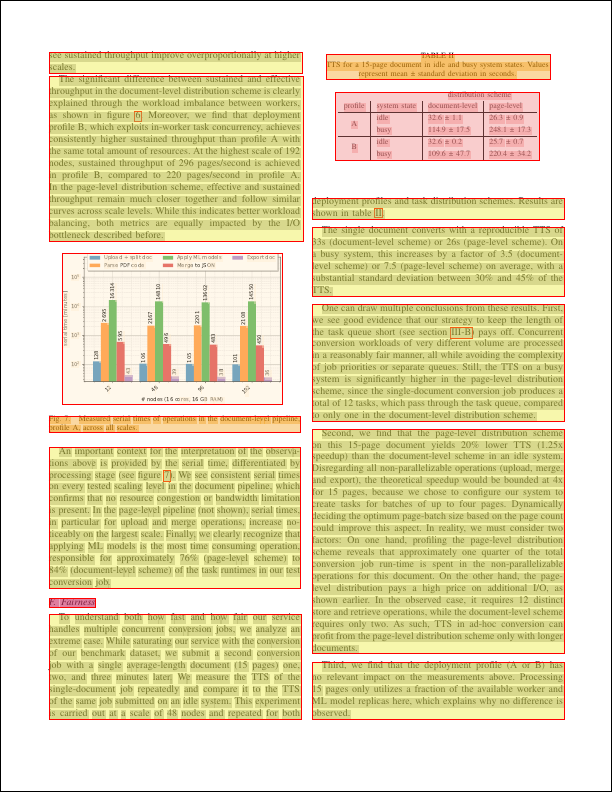
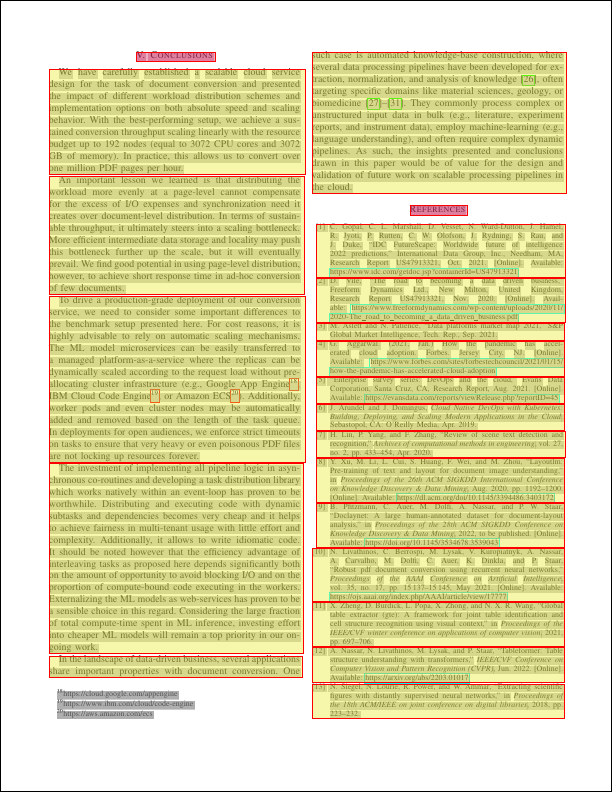
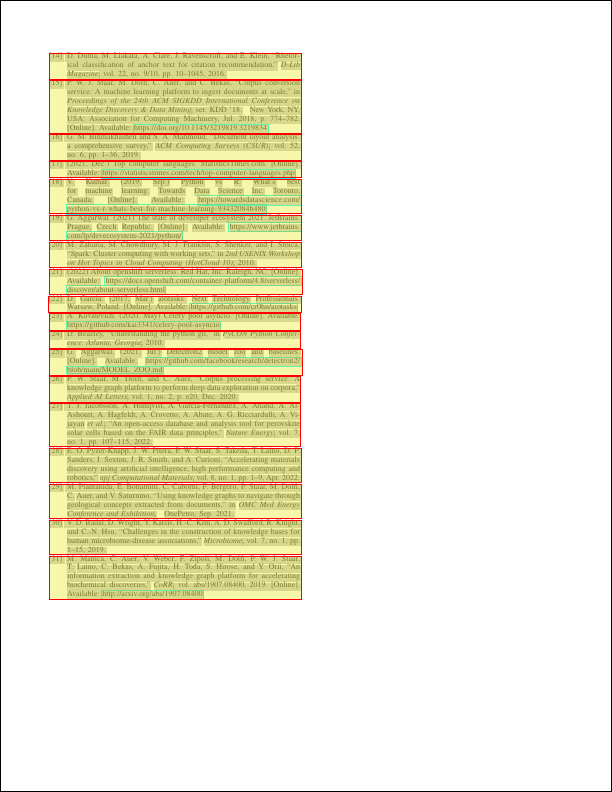

In [12]:
# Iterare output files and visualize the output
for output_file in Path(output_dir).rglob("json*.zip"):
    with ZipFile(output_file) as archive:
        all_files = archive.namelist()
        for name in all_files:
            if not name.endswith(".json"):
                continue
            
            basename = name.rstrip('.json')
            doc_jsondata = json.loads(archive.read(f"{basename}.json"))
            doc_cellsdata = json.loads(archive.read(f"{basename}.cells"))                

            visualize_document_bboxes(doc_jsondata, doc_cellsdata)